# AVISO Inversion with all data and swath data, no error

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, build_h_matrix
from aviso_rossby_wave import reverse_vector, forecast_ssh
from aviso_rossby_wave import build_swath, inversion, make_error_over_time

## Model coefficients such as starting date, number of waves etc.

In [2]:
day0, day1 = 0, 4 # 
Tdim = day1 - day0
time_range = 8 * (day1 - day0)
start_date = '2016-06-01' ## starting date
n_waves = '190' #number of waves
exp = 1 # R_over_P = K^-1

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]

In [5]:
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
date_time = avisso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-06-01T00:00:00.000000000')

In [6]:
ssha_time_mean = SSHA.mean(axis = -1)

In [7]:
SSHA = SSHA - SSHA[day0 : day0 + 30].mean(axis = 0) # - SSHA.mean(axis = 0)

In [8]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

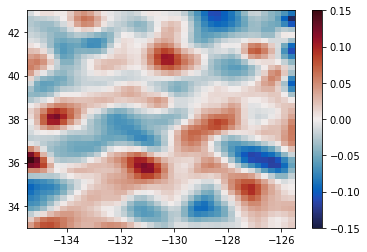

In [9]:
plt.pcolormesh(lon, lat, SSHA[:, :, 0], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
plt.colorbar()

#### Rossby wave vertical modes

In [10]:
MModes = 1

### Inversion with selecetd swath data points

In [11]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

### parameters

In [12]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
Psi = strat_ds.Psi.data

### the aviso data is sampled at 5-day intervals
#### use the 60-day data of the forward model (filtered AVISO data)

#### Rossby wave estimate

In [13]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date + '_' + n_waves + 'waves.nc') # forward model

In [14]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

In [15]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

#### assimilate multiple days of data

In [16]:
MSLA0 = wave_ds.MSLA_forward.data[:, :, day0:day1] #Filtered SSH

In [17]:
### assess skill, get indices
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time) # skill marrix

100%|███████████████████████████████████████████| 190/190 [00:03<00:00, 58.81it/s]


#### Number of models/waves

In [18]:
M = l_n.size * k_n.size
M

190

#### Plot skill matrix

In [19]:
kk, ll = np.meshgrid(k_n, l_n)
kk.shape, ll.shape

((19, 10), (19, 10))

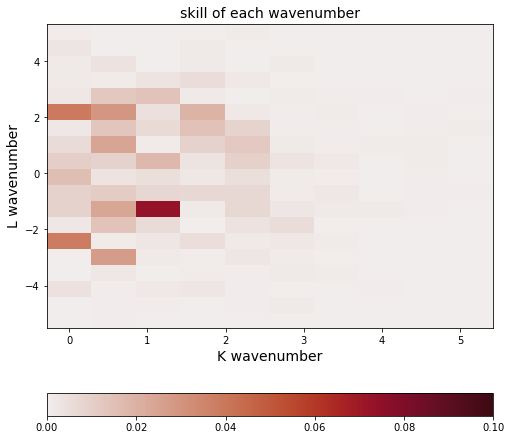

In [20]:
# better plot: not saturated, maybe magnitude + log
plt.figure(figsize = (8, 8))
plt.pcolor(kk, ll, skill[:, :, 0], cmap = cmo.cm.amp, vmin = 0, vmax = 0.1)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_KLwaves_' + str(M) + '.png')

#### Build basis function H matrix

In [21]:
dlon = lon - lon.mean()
dlat = lat - lat.mean()
    
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
omega = np.zeros([len(k_n), len(l_n), MModes])

nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            omega[kk, ll, mm] =  (Beta * k_n[kk, mm]) / (k_n[kk, mm] ** 2 + l_n[ll, mm] ** 2 + Rm ** -2)
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(l_n[ll, mm] * dlon[int(Iindex[count])] + k_n[kk, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(Tindex[count])]) 
                H_sin[count, nn] = Psi[0, mm] * np.sin(l_n[ll, mm] * dlon[int(Iindex[count])] + k_n[kk, mm] * dlat[int(Jindex[count])] + omega[kk, ll, mm] * T_time[int(Tindex[count])])
            nn += 1

H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

In [22]:
H_all.shape

(6400, 380)

#### signal to noise ratio

Signal to noise ratio decreases in proportion to $k^{-1}$

In [23]:
counter = 0
kl, P_over_R = np.zeros(2 * M), np.zeros([2 * M, 2 * M])
for kk in k_n:
    for ll in l_n:
        kl[2*counter] = np.sqrt(kk ** 2 + ll ** 2)
        kl[2*counter+1] = np.sqrt(kk ** 2 + ll ** 2)
        P_over_R[2*counter, 2*counter] = kl[2*counter] ** exp
        P_over_R[2*counter+1, 2*counter+1] = kl[2*counter + 1] ** exp
        counter += 1

#### solve for amplitudes with all data

In [24]:
amp_all_data, ssh_estimated = inversion(SSHA_vector, H_all, P_over_R) # X - 30 day solution 

In [25]:
SSHA_vector.shape, H_all.shape, P_over_R.shape

((6400,), (6400, 380), (380, 380))

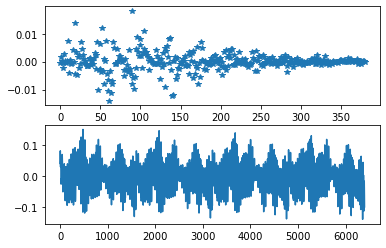

In [26]:
plt.subplot(211)
plt.plot(amp_all_data, '*')
plt.subplot(212)
plt.plot(ssh_estimated)

#### build satellite swath

In [27]:
swath_width, x_swath = 6, 20
days = np.arange(day0, day1)
days, days.size, len(days)

(array([0, 1, 2, 3]), 4, 4)

In [28]:
# indice, 
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

In [29]:
#tindex is returned by the function, x, y indices are the same for each snapshots but need to be repeated here
#xvalid_index, yvalid_index =  np.repeat(xindex, len(days)), np.repeat(yindex, len(days))
xvalid_index.shape, tindex.shape

((1800,), (1800,))

#### Add errors to the swaths

In [30]:
time_factor = np.arange(1, 1 + day1-day0)
time_factor , days

(array([1, 2, 3, 4]), array([0, 1, 2, 3]))

In [31]:
alpha_base = time_factor * 1e-3# baseline dialation error parameter
alpha_roll = time_factor * -.5e-3 #  np.arange(1, len(day)) # roll error parameter
alpha_timing =  time_factor * .5e-7 # timing error parameter, set to be much smaller than others
alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6 = time_factor * 4e-3, time_factor * 3e-3, time_factor* 2e-3, time_factor * 1e-3
alpha = np.stack([alpha_timing,  alpha_roll, alpha_base, alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6], axis = 1) 
# dimensions: [time, alphas]
alpha

array([[ 5.0e-08, -5.0e-04,  1.0e-03,  4.0e-03,  3.0e-03,  2.0e-03,
         1.0e-03],
       [ 1.0e-07, -1.0e-03,  2.0e-03,  8.0e-03,  6.0e-03,  4.0e-03,
         2.0e-03],
       [ 1.5e-07, -1.5e-03,  3.0e-03,  1.2e-02,  9.0e-03,  6.0e-03,
         3.0e-03],
       [ 2.0e-07, -2.0e-03,  4.0e-03,  1.6e-02,  1.2e-02,  8.0e-03,
         4.0e-03]])

In [32]:
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

4 40 6
450


#### sample SSH, errors and add white noise 

In [33]:
IND_TIMING = -7 
IND_ROLL = -6
IND_BASELINE = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

#### Sub-sample the SSH, correlated errors and H matrix

In [34]:
#### Sub-sample the SSH, correlated errors and H matrix
N = len(tindex) # number of data
MSLA_swath = np.zeros(N)
M = k_n.size * l_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([N, 2 * M + + Tdim * 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
for ii in range(N):
    IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
    MSLA_swath[ii] = ssh[ii]   + cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
    for nn in range(M):
        JIndex = 2 * MModes * nn # +  2 * mm # Model space
        H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

In [35]:
Valid_points = len(xvalid_index) // Tdim
err_basis_func = np.zeros([Valid_points, 7])
for tt in range(Tdim):
    for ii in range(Valid_points):
        #timing error
        err_basis_func[ii, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
        # roll error = alpha[1] * Xc^1
        err_basis_func[ii, IND_ROLL] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
        # baseline dialation error = alpha[2] * Xc^2
        err_basis_func[ii, IND_BASELINE] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
        # phase error 
        H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
        H_pos = np.heaviside(xc1_valid[tt, ii], 1) # 
        err_basis_func[ii, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
        err_basis_func[ii, IND_PHASE4] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
        err_basis_func[ii, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
        err_basis_func[ii, IND_PHASE6] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

In [36]:
### fill the error basis function part of the H matrix
for tt in range(Tdim):
    print(2 * M + tt * 7 , 2 * M + (tt+1) * 7)
    H_swath[tt*Valid_points:(tt+1)*Valid_points, 2 * M + tt * 7 : 2 * M + (tt+1) * 7] = err_basis_func

380 387
387 394
394 401
401 408


#### signal to noise ratio

In [37]:
p_basis_matrix = np.zeros([Tdim * 7, Tdim * 7])
np.fill_diagonal(p_basis_matrix, np.abs(alpha.flatten()))

In [38]:
counter = 0
exp = 1 # exp = 1 works the best so far
alpha_factor = 1e3
kl = np.zeros(2 * M)
P_over_R = np.zeros([Tdim, 2 * M + Tdim * 7, 2 * M +  Tdim * 7])

for tt in range(Tdim):
    P_over_R[tt, 2 * M : 2 * M  +  Tdim  * 7, 2 * M   : 2 * M  +  Tdim  * 7] = p_basis_matrix * alpha_factor

counter = 0
for kk in k_n:
    for ll in l_n:
        kl[counter] = np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        P_over_R[:, 2 * counter, 2 * counter] = kl[counter] ** exp
        P_over_R[:, 2 * counter + 1, 2 * counter + 1] = kl[counter] ** exp
        counter += 1 

In [39]:
Y_vector = Y_v #.flatten()# Reshape Y_v to a 1D array
H_matrix = H_swath #.reshapezz((Tdim * Valid_points, 2 * M + Tdim * 7))
P_matrix = P_over_R.mean(axis = 0)

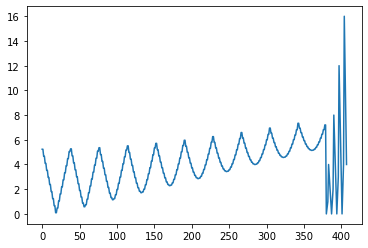

In [40]:
plt.plot(P_matrix.diagonal())

#### diagnostics: fit error to error basis functions

#### Solve for amplitudes

In [41]:
MSLA_swath.shape, H_swath.shape, P_over_R.shape

((1800,), (1800, 408), (4, 408, 408))

In [42]:
amp_swath, ssh_estimated_swath = inversion(MSLA_swath, H_swath, P_matrix) # assimilate the filtered AVISO SSH + error

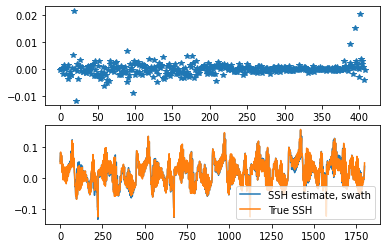

In [43]:
plt.subplot(211)
plt.plot(amp_swath, '*') # plot the dominant wave in pjhysical space, plot 2-D wavenumber space
plt.subplot(212)
plt.plot(ssh_estimated_swath, label = 'SSH estimate, swath')
plt.plot(MSLA_swath, label = 'True SSH')
plt.legend()

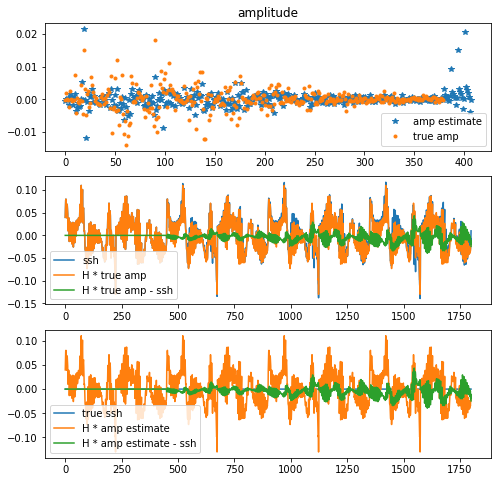

In [44]:
plt.figure(figsize = (8, 8,))
plt.subplot(311)
plt.plot(amp_swath[:], '*', label = 'amp estimate')
plt.plot(amp[:], '.', label = 'true amp')
plt.title('amplitude')
plt.legend()

plt.subplot(312)
#plt.plot(MSLA_fwd[:, :, day0:day1].flatten(), label = 'true ssh')
#plt.plot(ssh_estimated_swath, label = 'est. ssh')
#amp_err = np.append(amp[:], alpha.flatten())
#H_amp_all = np.matmul(H_all[:], amp)
#plt.plot(H_amp_all, label = 'H_all * true amp')
plt.plot(ssh,  label = 'ssh')
H_amp = np.matmul(H_swath[:, :-7*Tdim], amp)
plt.plot(H_amp, label = 'H * true amp')
plt.plot(H_amp - ssh, label = 'H * true amp - ssh')

plt.legend()

plt.subplot(313)
plt.plot(Y_v[:], label = 'true ssh')
#plt.plot(ssh_estimated_swath, label = 'est. ssh')
#amp_err = np.append(amp[:], alpha.flatten())
H_amp = np.matmul(H_swath[:][:, :-7*Tdim], amp)
plt.plot(H_amp, label = 'H * amp estimate')
plt.plot(H_amp - ssh, label = 'H * amp estimate - ssh')

#plt.plot(H_amp - ssh, label = 'H * amp - true ssh')
plt.legend()

#### Reverse the vectorization on the swaths

In [45]:
# Split the data for two days
num_days = len(days)
num_swaths_per_day = len(xvalid_index) // num_days
ssh_diff = np.zeros([num_days])

# Recover the first-day swaths
ssh_estimated_maps_day1 = np.zeros((nx, ny))
ssh_true_maps_day1 = np.zeros((nx, ny))
for i in range(num_swaths_per_day):
    ssh_estimated_maps_day1[xvalid_index[i], yvalid_index[i]] = ssh_estimated_swath[i]
    ssh_true_maps_day1[xvalid_index[i], yvalid_index[i]] = MSLA_swath[i]
    ssh_diff[0] = np.sqrt(np.mean((ssh_true_maps_day1 - ssh_estimated_maps_day1) ** 2)) / np.sqrt(np.mean((ssh_true_maps_day1) ** 2))

# Recover the second-day swaths
ssh_estimated_maps_day2 = np.zeros((nx, ny))
ssh_true_maps_day2 = np.zeros((nx, ny))
for i in range(num_swaths_per_day, num_swaths_per_day * 2):
    ssh_estimated_maps_day2[xvalid_index[i], yvalid_index[i]] = ssh_estimated_swath[i]
    ssh_true_maps_day2[xvalid_index[i], yvalid_index[i]] = MSLA_swath[i]
    ssh_diff[1] = np.sqrt(np.mean((ssh_true_maps_day2 - ssh_estimated_maps_day2) ** 2)) / np.sqrt(np.mean((ssh_true_maps_day2) ** 2))   

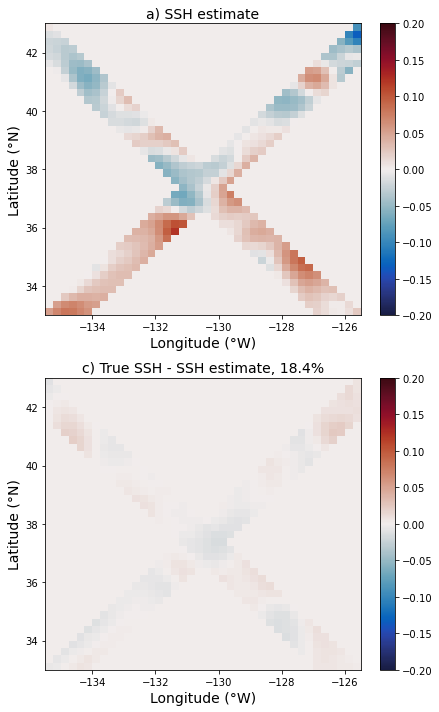

In [46]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_estimated_maps_day1, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true_maps_day1 - ssh_estimated_maps_day1, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff[0] * 100)[:4] + '%', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(time[0])[:10] + '_no_error.png')

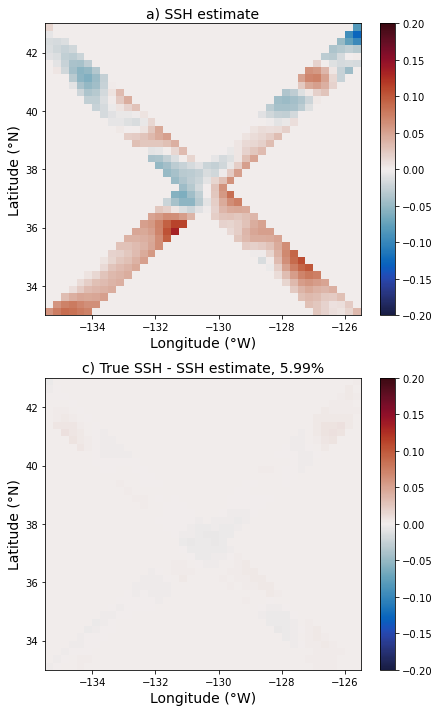

In [47]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_estimated_maps_day2, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true_maps_day2 - ssh_estimated_maps_day2, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff[1] * 100)[:4] + '%', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+str(time[1])[:10] + '_no_error.png')

In [48]:
np.mean((ssh_estimated_maps_day1 - ssh_estimated_maps_day2) ** 2)

1.5448280246316528e-05

#### Make predictions of SSH based on the estimated amplitudes:
#### Swath data, with errors

In [49]:
#amp_syn = kl ** 1 

In [50]:
#amp_swath[np.abs(amp_swath)>1e0] =0
#amp[np.abs(amp)>1e0] =0
#amp_syn[np.abs(amp_syn)>1e0] =0
#amp_all_data[np.abs(amp_all_data)>1e0] =0

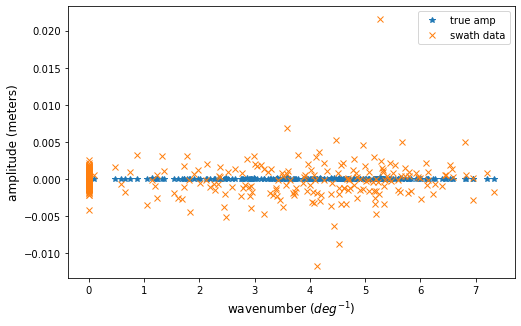

In [51]:
plt.figure(figsize = (8, 5))
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'true amp')
#plt.plot(kl, amp_all_data , '*', label = 'all data')
plt.plot(kl, amp_swath[:-7*Tdim], 'x', label = 'swath data')
#plt.plot(kl, amp_syn ** 2, 'x', label = 'swath data')
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')

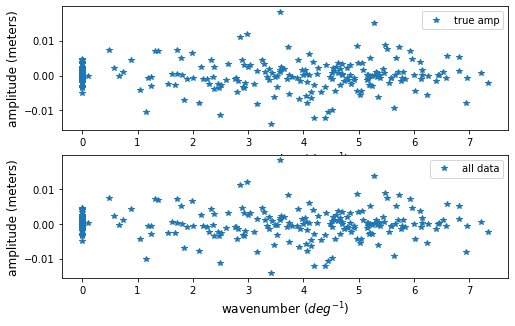

In [52]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp, '*', label = 'true amp')
plt.legend()

plt.subplot(212)

#plt.plot(kl, amp_swath, '.', label = 'swath data')
plt.plot(kl, amp_all_data , '*', label = 'all data')
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.legend()
plt.savefig('amp_k' + str(exp) +'.png')

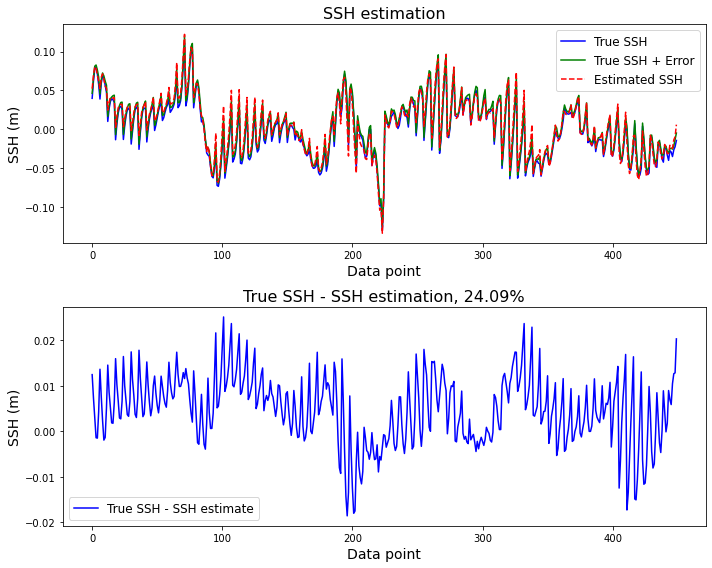

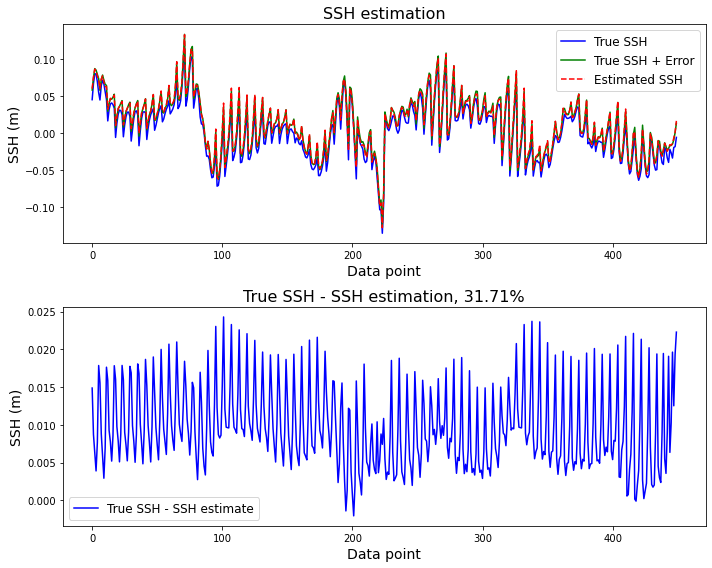

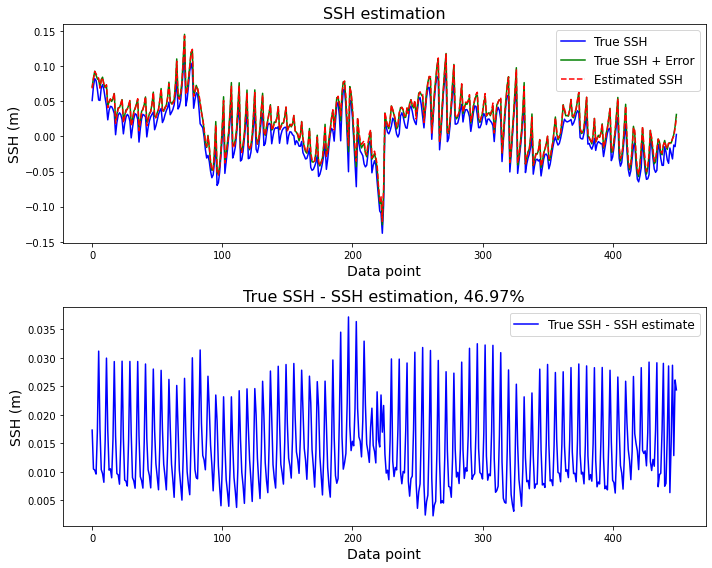

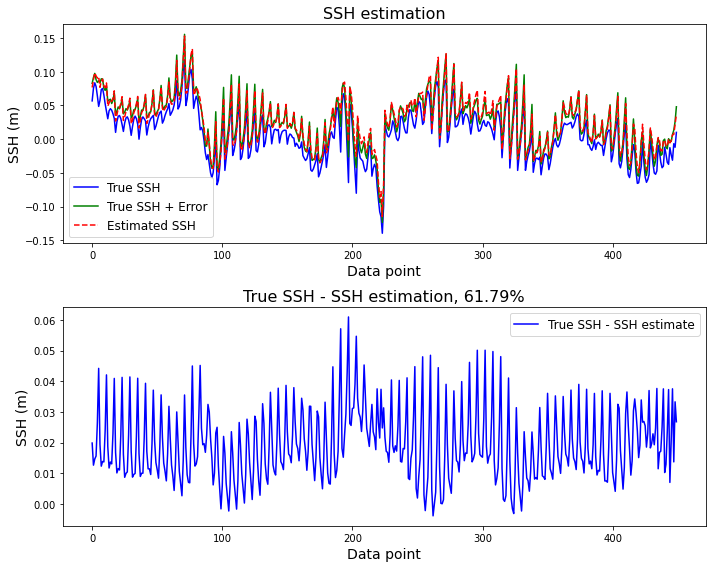

In [53]:
Valid_points = timing_err_valid.shape[1]
ssh_diff = np.zeros([Tdim, Valid_points])
diff_percent = np.zeros([Tdim])
for tt in range(Tdim):
    
    ssh_diff[tt] = ssh_estimated_swath[tt * Valid_points : (tt+1) * Valid_points] - ssh[tt * Valid_points : (tt+1) * Valid_points]
    
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    
    plt.plot(ssh[tt * Valid_points : (tt+1) * Valid_points], 'b-', label='True SSH')
    plt.plot(MSLA_swath[tt * Valid_points : (tt+1) * Valid_points], 'g', label = 'True SSH + Error')
    plt.plot(ssh_estimated_swath[tt * Valid_points : (tt+1) * Valid_points], 'r--', label='Estimated SSH')
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('SSH estimation', fontsize=16)
    plt.legend(fontsize=12)

    plt.subplot(212)
    diff_percent[tt] = np.sqrt(ssh_diff[tt]**2).mean() / np.sqrt(ssh[tt * Valid_points : (tt+1) * Valid_points]**2).mean()
    plt.plot(ssh_diff[tt], 'b', label='True SSH - SSH estimate')
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('True SSH - SSH estimation, ' + str(diff_percent[tt] * 100)[:5] + '%', fontsize=16)
    #plt.title('True SSH - SSH estimation', fontsize=16)
    plt.legend(fontsize=12)
    

    plt.tight_layout()
    
    plt.savefig('./ssh_err_estimate/ssh_err_parameter_'+  str(date_time[tt])[:10] +'.png')

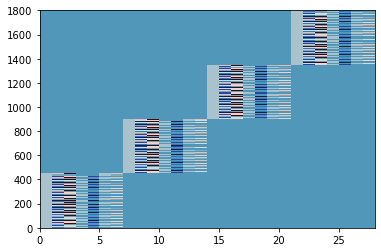

In [54]:
plt.pcolormesh(H_swath[:, -7 * Tdim :], cmap = cmo.cm.balance)

In [55]:
amp_1step, ssh_estimated_swath = inversion(MSLA_swath, H_matrix, P_matrix)
err_est = np.matmul(H_matrix[:, -7* Tdim:], amp_1step[-7 * Tdim:])

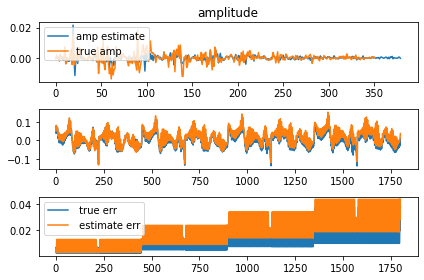

In [56]:
plt.subplot(311)
plt.plot(amp_swath[:-7 * Tdim], label = 'amp estimate')
plt.plot(amp[:-7 * Tdim], label = 'true amp')
plt.title('amplitude')
plt.legend()

plt.subplot(312)
plt.plot(ssh)
plt.plot(ssh_estimated_swath)

plt.subplot(313)
plt.plot(cor_err, label = ' true err')
plt.plot(err_est, label = ' estimate err')
plt.legend()
plt.tight_layout()

#### One approach sanity check: fit errors to seven error basis functions

In [57]:
HTH = np.matmul(H_matrix[:, -7 * Tdim:].T, H_matrix[:, -7 * Tdim:])

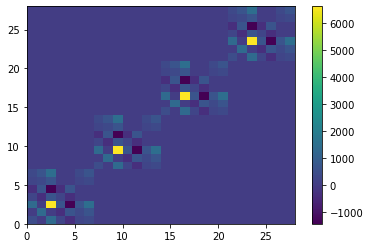

In [58]:
plt.pcolormesh(HTH)
plt.colorbar()

In [59]:
amp_err_only,  err_estimated_swath = inversion(cor_err, H_matrix[:, -7*Tdim:], P_matrix[-7*Tdim:, -7*Tdim:])
err_est_err_only = np.matmul(H_matrix[:, -7*Tdim:], amp_1step[-7*Tdim:])

In [60]:
amp_diff_1step = amp_1step[-7 * Tdim:] - alpha.flatten()
amp_diff_err_only = amp_err_only[-7 * Tdim:] - alpha.flatten()

In [61]:
import seaborn as sns

In [62]:
err_1step = amp_swath[-7 * Tdim:].reshape(Tdim, 7)
err_diff_1step = amp_diff_1step.reshape(Tdim, 7)

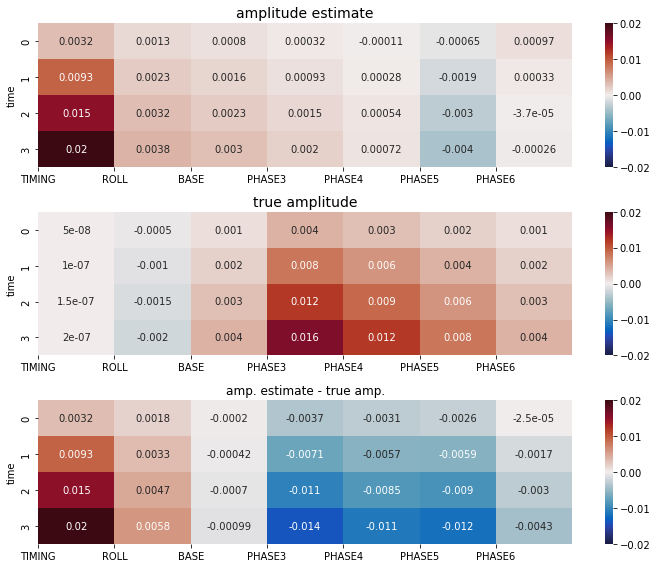

In [63]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
sns.heatmap(err_1step, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('amplitude estimate', fontsize = 14)

plt.subplot(312)
sns.heatmap(alpha, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('true amplitude', fontsize = 14)
#plt.colorbar()

plt.subplot(313)
plt.title('amp. estimate - true amp.')
#plt.pcolormesh(amp_diff_1step,  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
sns.heatmap(err_diff_1step, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
#plt.title('true amplitude', fontsize = 14)
plt.tight_layout()

plt.savefig('./corr_matrix.png')

In [64]:
amp_err_only.shape

(28,)

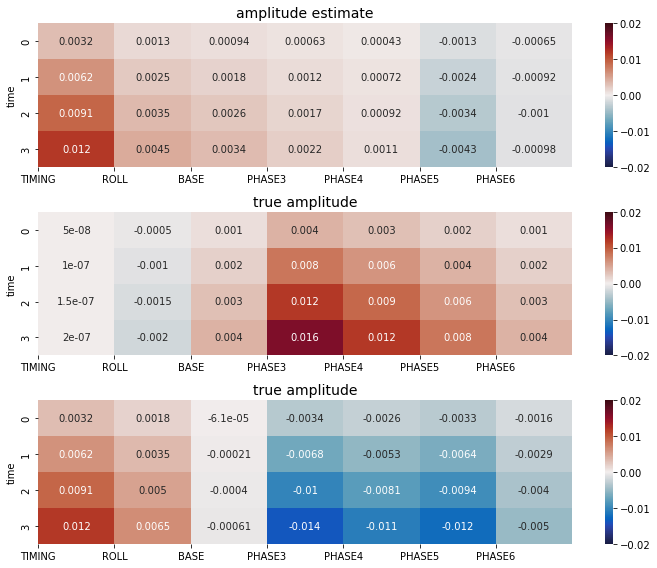

In [65]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
sns.heatmap(amp_err_only.reshape(Tdim, 7), annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('amplitude estimate', fontsize = 14)

plt.subplot(312)
sns.heatmap(alpha, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(4)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('true amplitude', fontsize = 14)
#plt.colorbar()

plt.subplot(313)
plt.title('amp. estimate - true amp.')
#plt.pcolormesh(amp_diff_1step.reshape(Tdim, 7),  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
sns.heatmap(amp_diff_err_only.reshape(Tdim, 7), annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('true amplitude', fontsize = 14)
plt.tight_layout()

plt.savefig('./corr_matrix.png')

#### compare the training data (truth) to estimate

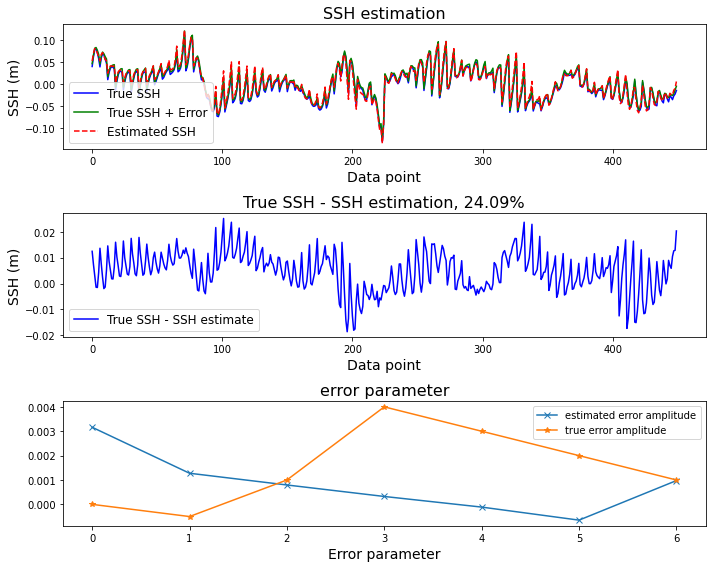

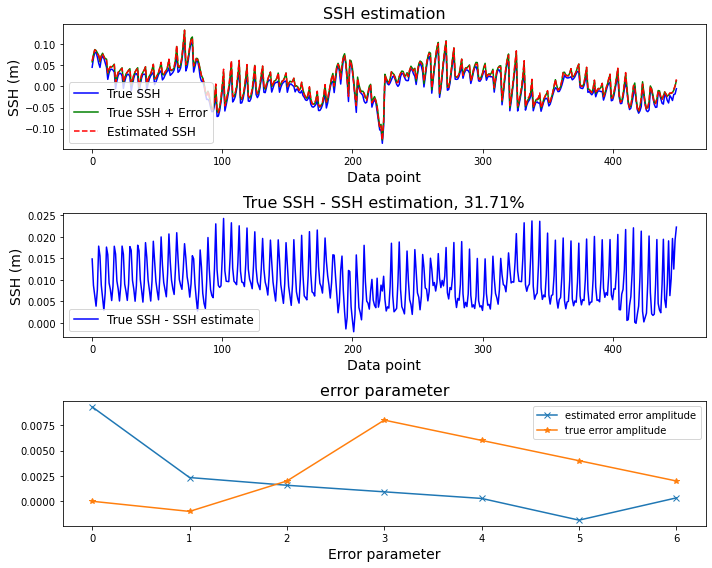

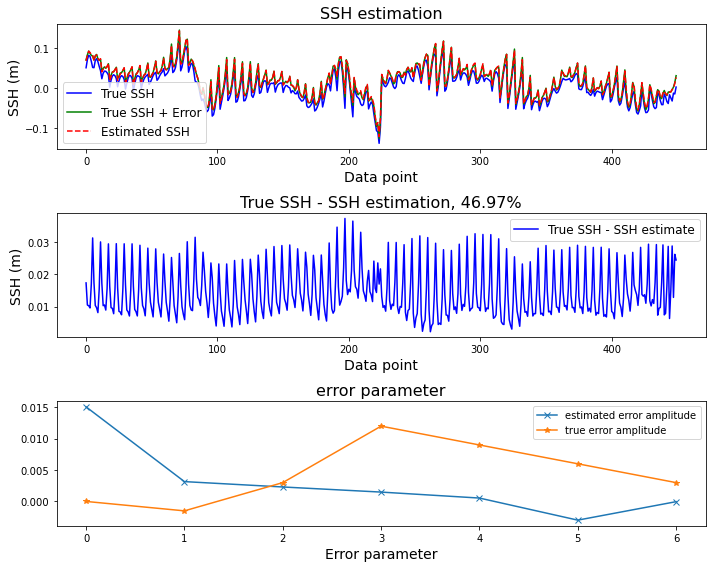

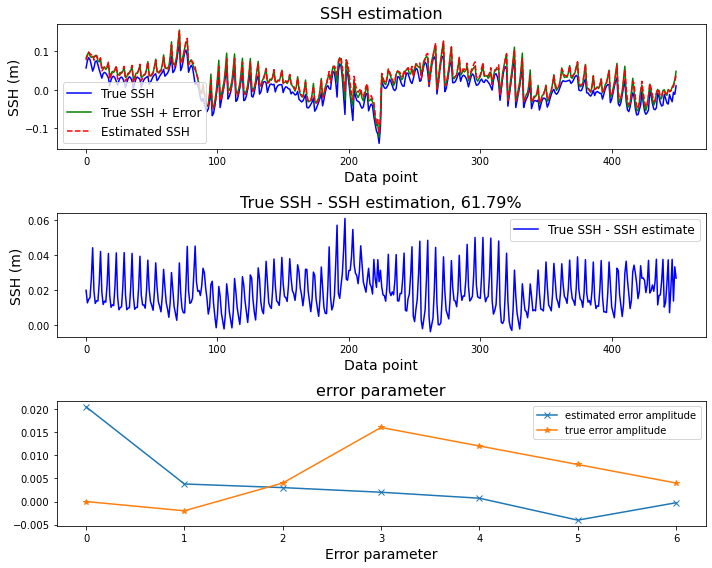

In [66]:
ssh_diff = np.zeros([Tdim, Valid_points])
diff_percent = np.zeros([Tdim])
for tt in range(Tdim):
    
    ssh_diff[tt] = ssh_estimated_swath[tt * Valid_points : (tt+1) * Valid_points] - ssh[tt * Valid_points : (tt+1) * Valid_points]
    
    plt.figure(figsize=(10, 8))
    plt.subplot(311)
    
    plt.plot(ssh[tt * Valid_points : (tt+1) * Valid_points], 'b', label='True SSH')
    plt.plot(MSLA_swath[tt * Valid_points : (tt+1) * Valid_points], 'g-', label = 'True SSH + Error')
    plt.plot(ssh_estimated_swath[tt * Valid_points : (tt+1) * Valid_points], 'r--', label='Estimated SSH')
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('SSH estimation', fontsize=16)
    plt.legend(fontsize=12)

    plt.subplot(312)
    diff_percent[tt] = np.sqrt(ssh_diff[tt]**2).mean() / np.sqrt(ssh[tt * Valid_points : (tt+1) * Valid_points]**2).mean()
    plt.plot(ssh_diff[tt], 'b', label='True SSH - SSH estimate')
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('True SSH - SSH estimation, ' + str(diff_percent[tt] * 100)[:5] + '%', fontsize=16)
    
    plt.legend(fontsize=12)
    

    plt.subplot(313)
    plt.title('error parameter', fontsize=16)
    plt.plot(err_1step[tt], '-x', label = 'estimated error amplitude')
    plt.plot(alpha[tt], '-*', label = 'true error amplitude')
    plt.xlabel('Error parameter', fontsize=14)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('./ssh_err_estimate/ssh_err_parameter_'+  str(date_time[tt])[:10] +'.png')

In [67]:
from scipy.stats import norm
ssh_diff = ssh_estimated_swath - ssh

In [68]:
amp_1step.shape

(408,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


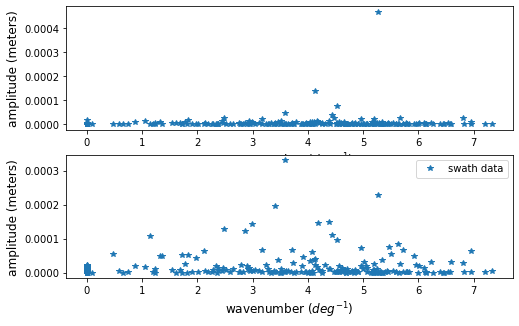

In [69]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step[:Tdim * -7] ** 2  , '*', label = 'true amp')
plt.subplot(212)
plt.legend()

plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'swath data')
plt.legend()